In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, time, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

#models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor

 
mpl.rcParams['lines.linewidth'] = 2

figsize=(12,9)

np.random.seed(238746)


import warnings
warnings.filterwarnings("ignore")

TRAIN-TEST SPLIT DATE 

In [2]:
SplitTestDate = "2019-06-23"

### MODEL SELECTION AND FEATURE SELECTION

In [3]:
models = {
    "xgb" : xgb.XGBRegressor(n_estimators=500, learning_rate=0.1),
    "extra": ExtraTreesRegressor(n_estimators=500),
    #"forest" : RandomForestRegressor(n_estimators=100)
}

features_for_model = {

    "xgb" : ['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"],
    "extra": ['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"],
    "forest": ['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"],
    
    "final": [1027, 1035,  144, 1051,  546, 1058,  549, 1065,  554,  686,  688,
       1206,"group_A","group_B",'scaled_dayofyear',"xgb","extra"]
 
}

finalreg = RandomForestRegressor(n_estimators=100)

### SCALING FUNCTIONS

In [4]:
min_max_scaler = preprocessing.MinMaxScaler()

def scale(feature, scaler = min_max_scaler):
    size = len(feature)
    return scaler.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
def unscale(scaled, original, scaler = min_max_scaler):
    size2 = len(scaled)
    size1 = len(original)
    return scaler.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]

### MAPE AND PLOT FUNCTIONS

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_results(ytrue, prediction, label):
    df_ytrue = pd.DataFrame(ytrue)
    df_ytrue['predicted'] =  prediction 
    plt.plot(df_ytrue[label],label='data')
    plt.plot(df_ytrue['predicted'],label='predicted')
    plt.xticks(rotation=45)
    mape = mean_absolute_percentage_error(df_ytrue[label],df_ytrue['predicted'])

    plt.title("Forecasting on Test Set MAPE=%.3f"%mape)
    plt.legend();
    plt.show()
    return mape

def scaled_mape(prediction, y_test, rescale):
    results = pd.DataFrame(columns = ["sku","target","prediction"])

    for sku in y_test["sku"].unique():

        pred_sku = prediction[np.where(y_test["sku"] == sku)]
        originals = rescale.loc[rescale["sku"] == sku]["target"]
        pred = unscale(pred_sku,originals)

        results = pd.concat([results, pd.DataFrame({
            "date" : y_test[y_test["sku"] == sku]["date"],
            "sku" : y_test[y_test["sku"] == sku]["sku"],
            "scaled_target" : y_test[y_test["sku"] == sku]["scaled_target"],
            "target" : y_test[y_test["sku"] == sku]["target"],
            "scaled_prediction" : pred_sku,
            "prediction" : pred
        })])
    results = results.dropna().set_index("date")
    return mean_absolute_percentage_error(results["target"],results["prediction"])

    
    
    
def plot_scaled_results(prediction, y_test, rescale):
    results = pd.DataFrame(columns = ["sku","target","prediction"])

    for sku in y_test["sku"].unique():

        pred_sku = prediction[np.where(y_test["sku"] == sku)]
        originals = rescale.loc[rescale["sku"] == sku]["target"]
        pred = unscale(pred_sku,originals)

        results = pd.concat([results, pd.DataFrame({
            "date" : y_test[y_test["sku"] == sku]["date"],
            "sku" : y_test[y_test["sku"] == sku]["sku"],
            "scaled_target" : y_test[y_test["sku"] == sku]["scaled_target"],
            "target" : y_test[y_test["sku"] == sku]["target"],
            "scaled_prediction" : pred_sku,
            "prediction" : pred
        })])
    results = results.dropna().set_index("date")

    return plot_results(results["target"], results["prediction"], "target"), results

### FUNCTION THAT COMPUTE THE CROSS PREDICTION OF THE TRAINING SET

In [6]:
def predict_training(model,X,y,label = "scaled_target",span = 24):
    
    #k = number of folds
    k = int(len(X)/span)
    
    prediction = pd.DataFrame(columns = ["date","sku","pred"])    
    
    for fold in range(0,k):
        if fold != k - 1:
            validation = X.iloc[fold*span:(fold+1)*span]
        else:
            validation = X.iloc[fold*span:]
        
        training = X[~X.index.isin(validation.index)]
        y_tr  = y[~y.index.isin(validation.index)]
        y_val  = y[y.index.isin(validation.index)]
        
        model.fit(training, y_tr[label])
        partial_pred = pd.DataFrame()
        partial_pred["date"] = y_val["date"]
        partial_pred["sku"] = y_val["sku"]
        partial_pred["pred"] = model.predict(validation)
        partial_pred.set_index(validation.index)
        prediction = prediction.append(partial_pred)
        
    return prediction

### FUNCTION THAT COMPUTE THE PREDITION OF THE TEST SET STACKING ALL THE MODELS

In [31]:
def StackingPred(models,final_model, X_train, y_train, X_test,y_test,features_for_model,rescale = None, span = 24, label = "scaled_target"):
    final_prediction = []
    onehot_encoder = OneHotEncoder(sparse=False)
    
    y_traing = y_train
    X_traing = X_train
    sku_dummies = pd.get_dummies(y_traing["sku"]) > 0
    sku_dummies_df = pd.DataFrame(sku_dummies, index = X_traing.index)
    X_traing = pd.concat([sku_dummies_df,X_traing],axis = 1)
    
    for week in y_test.date.unique():
        print(week)
        
        test = X_test.loc[y_test.date == week]
        y_te = y_test.loc[y_test.date == week]
        
        #TRAIN SET PREDICTION WITH MODELS
        results_dict = {}
        print(X_traing.dropna().shape)
        for name, model in models.items():
            
            print("train with %s shape: %d x %d" %(name,X_traing.shape[0],X_traing.shape[1]))            
            results_dict.update({name : predict_training(model, X_traing, y_traing,label,span)})

        train_result = pd.DataFrame(index = X_traing.index)
        for name,r in results_dict.items():
            train_result["date"] = r["date"]
            train_result["sku"] = r["sku"]
            train_result[name] = r["pred"]
        onehot_encoded = pd.get_dummies(y_te["sku"]) > 0
        onehot = pd.DataFrame(onehot_encoded, index = test.index)
        test = pd.concat([onehot,test],axis = 1)

        #TEST SET PREDICTION WITH MODELS
        prediction_df = pd.DataFrame()
        for name, model in models.items():
            print("test with %s" %name)
          
            model = model.fit(X_traing, y_traing[label])

            prediction_df[name] = model.predict(test)
        prediction_df.index = test.index

        #DUMMY VARIABLES FOR FINAL TRAIN AND TEST
        final_train = pd.concat([X_traing,train_result[models.keys()]],axis = 1)
        final_test = pd.concat([test,prediction_df[models.keys()]],axis = 1)
       # print(final_test)
        #TRAIN ON TRAIN PREDICTIONS AND PREDICTION ON TEST PREDICTIONS
        print("final prediction")


        final_model.fit(final_train[features_for_model["final"]], y_traing[label])
        p =  final_model.predict(final_test[features_for_model["final"]])
        final_prediction = np.append(final_prediction,p)
        if rescale is not None:
            print("MAPE finale %.5f" % scaled_mape(p, y_te, rescale))
            print("MAPE xgb %.5f" % scaled_mape(np.array(prediction_df["xgb"]), y_te, rescale))
            print("MAPE extra %.5f" % scaled_mape(np.array(prediction_df["extra"]), y_te, rescale))
        X_traing = pd.concat([X_traing,test]).reset_index().drop(columns=["index"])
        y_traing = pd.concat([y_traing,y_te]).reset_index().drop(columns=["index"])
    return final_prediction, train_result, prediction_df

### GET PROCESSED DATA FROM CSV

In [32]:
df = pd.read_csv('data/processed_train.csv',index_col = 0)
df_test = pd.read_csv('data/processed_test.csv',index_col = 0)

df = df.loc[df.scope == 1]
df_test = df_test.loc[df.scope == 1]
df.date = df.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df_test.date = df_test.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

df = df.sort_values(by=["date",'sku'])
df_test = df_test.sort_values(by=["date",'sku'])

In [33]:
rescale_df = pd.concat([df,df_test])[["target","sku"]].dropna()

In [34]:
df = pd.concat([df,df_test])

### FIRST FEATURE SELECTION

In [35]:
simple_df = df[['scaled_quarter','scaled_month','scaled_year','scaled_price_diff1',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2",
                "date","sku","scaled_target","target"]]
simple_df = simple_df.dropna().set_index("date")
simple_train = simple_df[:SplitTestDate].reset_index()
simple_test = simple_df[SplitTestDate:].reset_index()

In [36]:
X_train = simple_train[['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"]]

In [37]:
y_train = simple_train[["date","sku","scaled_target","target"]]

In [38]:
X_test = simple_test[X_train.columns]

In [39]:
y_test = simple_test[y_train.columns]

In [40]:
X = pd.concat([X_train,X_test.loc[y_test.date == y_test.date.unique()[0]]])


In [41]:
X.reset_index().drop(columns=["index"])

,scaled_month,group_A,group_B,BRAND2,BRAND4,scaled_dayofyear,scaled_dayofmonth,scaled_weekofyear,scaled_sales1,scaled_sales2,scaled_sales3,scaled_promo,scaled_diff1,scaled_diff2,percentage_diff1,scaled_price,scaled_rolling2
0,1.000000,False,True,True,False,1.000000,1.000000,1.000000,0.407090,0.486490,0.359256,1.000000,0.079400,-0.047834,0.165436,0.611354,0.446790
1,1.000000,True,False,True,False,1.000000,1.000000,1.000000,0.090556,0.109741,0.138842,0.119108,0.019184,0.048286,0.064815,0.633333,0.100149
2,1.000000,True,False,True,False,1.000000,1.000000,1.000000,0.106018,0.102699,0.131821,0.203441,-0.003319,0.025803,-0.016304,0.777778,0.104359
3,1.000000,True,False,True,False,1.000000,1.000000,1.000000,0.098738,0.121289,0.154270,0.207252,0.022552,0.055532,0.068904,0.633333,0.110013
4,1.000000,False,True,False,True,1.000000,1.000000,1.000000,0.322606,0.418289,0.333547,0.990468,0.095683,0.010941,0.246065,0.579439,0.370447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,0.454545,True,False,True,False,0.484765,0.933333,0.490196,0.142010,0.192205,0.182352,0.077256,0.050195,0.040342,0.166026,0.961538,0.167107
1568,0.454545,False,True,False,True,0.484765,0.933333,0.490196,0.048828,0.116144,0.104440,0.048294,0.067316,0.055612,0.484927,0.677570,0.082486
1569,0.454545,True,False,False,True,0.484765,0.933333,0.490196,0.212171,0.254172,0.240136,0.226122,0.042001,0.027965,0.116567,0.961538,0.233171
1570,0.454545,True,False,False,True,0.484765,0.933333,0.490196,0.221990,0.253979,0.255097,0.198803,0.031988,0.033107,0.069733,0.718750,0.237985


### COMPUTE THE PREDICTION

In [42]:
res = StackingPred(models,finalreg, X_train, y_train, X_test,y_test,features_for_model,rescale = rescale_df, span = 36, label = "scaled_target")


2019-06-29T00:00:00.000000000
(1560, 29)
train with xgb shape: 1560 x 29
train with extra shape: 1560 x 29
test with xgb
test with extra
final prediction
MAPE finale 9.68924
MAPE xgb 10.10316
MAPE extra 10.02425
2019-07-06T00:00:00.000000000
(1572, 29)
train with xgb shape: 1572 x 29
train with extra shape: 1572 x 29
test with xgb
test with extra
final prediction
MAPE finale 9.23247
MAPE xgb 9.65321
MAPE extra 11.31158
2019-07-13T00:00:00.000000000
(1584, 29)
train with xgb shape: 1584 x 29
train with extra shape: 1584 x 29
test with xgb
test with extra
final prediction
MAPE finale 19.36874
MAPE xgb 20.42367
MAPE extra 19.67637
2019-07-20T00:00:00.000000000
(1596, 29)
train with xgb shape: 1596 x 29
train with extra shape: 1596 x 29
test with xgb
test with extra
final prediction
MAPE finale 21.94179
MAPE xgb 23.21854
MAPE extra 20.71951
2019-07-27T00:00:00.000000000
(1608, 29)
train with xgb shape: 1608 x 29
train with extra shape: 1608 x 29
test with xgb
test with extra
final predicti

In [43]:
res

(array([0.06816525, 0.10329267, 0.12414634, 0.19779574, 0.07519907,
        0.12565254, 0.15811142, 0.10812254, 0.08726076, 0.17560998,
        0.18788727, 0.14058643, 0.06838775, 0.1116046 , 0.11613817,
        0.14734281, 0.10764152, 0.16697997, 0.09470536, 0.10620041,
        0.08270884, 0.14842725, 0.13792117, 0.14163045, 0.12522668,
        0.19431113, 0.28870512, 0.21147909, 0.19785424, 0.30279245,
        0.23075105, 0.16059346, 0.19817382, 0.44263873, 0.28176637,
        0.38747742, 0.08410777, 0.34504026, 0.32206607, 0.3900241 ,
        0.22823147, 0.32616784, 0.28270287, 0.67573748, 0.09640374,
        0.61266598, 0.40558107, 0.53627866, 0.1034325 , 0.39808903,
        0.44983114, 0.39152579, 0.11924139, 0.4161887 , 0.44229171,
        0.44405329, 0.18161725, 0.41385704, 0.37063272, 0.4414954 ,
        0.3768541 , 0.22751307, 0.38075849, 0.19717312, 0.40607477,
        0.23943903, 0.20406336, 0.23723419, 0.41911397, 0.22364676,
        0.1390306 , 0.38766284, 0.43421999, 0.14

,date,sku,xgb,extra
0,2016-12-31,144,0.087539,0.134154
1,2016-12-31,546,0.041151,0.146450
2,2016-12-31,549,0.052546,0.105907
3,2016-12-31,554,0.081519,0.160064
4,2016-12-31,686,0.106810,0.140043
...,...,...,...,...
1831,2019-11-30,1035,0.094844,0.085509
1832,2019-11-30,1051,0.645868,0.636817
1833,2019-11-30,1058,0.131033,0.107403
1834,2019-11-30,1065,0.099870,0.088880


In [57]:
res[0][y_test.loc[y_test["sku"] == 144].index]

array([0.06816525, 0.06838775, 0.12522668, 0.08410777, 0.1034325 ,
       0.3768541 , 0.43421999, 0.52856461, 0.30123334, 0.13705068,
       0.09941233, 0.09278612, 0.09422079, 0.08994852, 0.63664037,
       0.50234844, 0.46703876, 0.26356292, 0.12049471, 0.08462025,
       0.36226843, 0.45420831, 0.43805178, 0.27151898])

### SHOW THE RESULTS

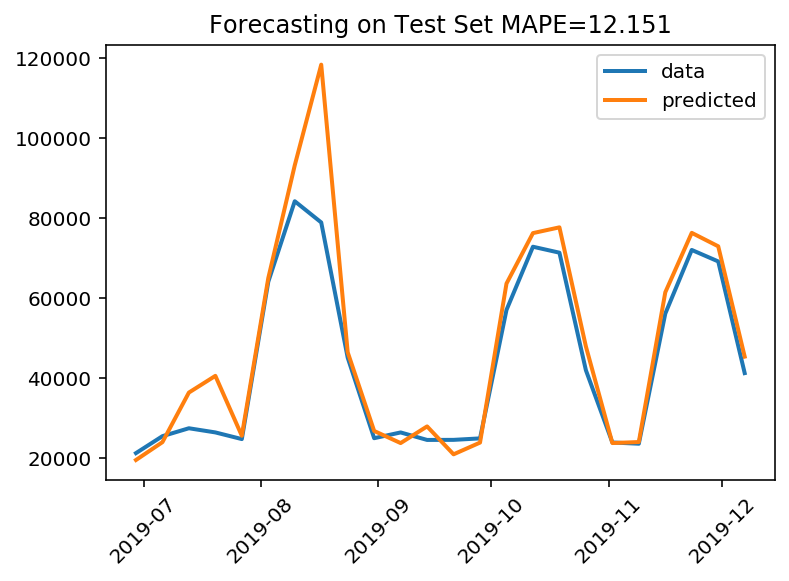

In [60]:
mape,results = plot_scaled_results(res[0][y_test.loc[y_test["sku"] == 686].index], y_test.loc[y_test["sku"] == 686], rescale_df)